<a href="https://colab.research.google.com/github/ArifAygun/ML_Calisma_Notebooklari/blob/main/Imputing_Missing_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Imputing Missing Data with Simple and Advanced Techniques**

Missing data occurs when there is no data stored for a variable of interest in a dataset. Depending on its volume, missing data can harm the findings of any data analysis or the robustness of machine learning models.

While dealing with missing data using Python, dropna() function from Pandas comes in handy. We use it to remove rows and columns that include null values. It also has several parameters such as axis to define whether rows or columns drop, how to determine if missing values occur in any or all of the rows/columns, and subset to select a group of columns or labels to apply the drop function on.

In [ ]:
df.dropna(axis=0, how='any', subset=None, inplace=False)

However, there are other and probably better ways of dealing with missing data. In this article, we will see how to impute (replace) missing data with simple and advanced techniques. We will first cover simple univariate techniques such as mean and mode imputation. Then, we will see forward and backward filling for time series data and we will explore interpolation such as linear, polynomial, or quadratic for filling missing values. Later, we will explore advanced multivariate techniques and learn how to impute missing values using machine learning with KNN and MICE.

While following the article, I encourage you to check out the Jupyter Notebook on my GitHub for the full analysis and code.

###Data
In this article, we will use travel times dataset from OpenMV.net. Using the following code, we will load the data by parsing the Date and StartTime columns and converting random values into missing values on the 10% of the MaxSpeed column.

In [5]:
# Read the original dataset
from google.colab import drive
drive.mount('/content/drive/')

%cd /content/drive/My Drive/Datasets/

import pandas as pd
import numpy as np
df = pd.read_csv("travel-times.csv")
df.head()

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/Datasets


,Date,StartTime,DayOfWeek,GoingTo,Distance,MaxSpeed,AvgSpeed,AvgMovingSpeed,FuelEconomy,TotalTime,MovingTime,Take407All,Comments
0,1/6/2012,16:37,Friday,Home,51.29,127.4,78.3,84.8,NaN,39.3,36.3,No,NaN
1,1/6/2012,08:20,Friday,GSK,51.63,130.3,81.8,88.9,NaN,37.9,34.9,No,NaN
2,1/4/2012,16:17,Wednesday,Home,51.27,127.4,82.0,85.8,NaN,37.5,35.9,No,NaN
3,1/4/2012,07:53,Wednesday,GSK,49.17,132.3,74.2,82.9,NaN,39.8,35.6,No,NaN
4,1/3/2012,18:57,Tuesday,Home,51.15,136.2,83.4,88.1,NaN,36.8,34.8,No,NaN


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Date            205 non-null    object 
 1   StartTime       205 non-null    object 
 2   DayOfWeek       205 non-null    object 
 3   GoingTo         205 non-null    object 
 4   Distance        205 non-null    float64
 5   MaxSpeed        190 non-null    float64
 6   AvgSpeed        205 non-null    float64
 7   AvgMovingSpeed  205 non-null    float64
 8   FuelEconomy     188 non-null    object 
 9   TotalTime       205 non-null    float64
 10  MovingTime      205 non-null    float64
 11  Take407All      205 non-null    object 
 12  Comments        24 non-null     object 
dtypes: float64(6), object(7)
memory usage: 20.9+ KB


In [9]:
# Generate random missing values on column MaxSpeed
mask = np.random.choice([True, False], size=df['MaxSpeed'].shape, p=[0.1, 0.9])
mask[mask.all(),-1] = 0
df['MaxSpeed'] = df['MaxSpeed'].mask(mask)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Date            205 non-null    object 
 1   StartTime       205 non-null    object 
 2   DayOfWeek       205 non-null    object 
 3   GoingTo         205 non-null    object 
 4   Distance        205 non-null    float64
 5   MaxSpeed        174 non-null    float64
 6   AvgSpeed        205 non-null    float64
 7   AvgMovingSpeed  205 non-null    float64
 8   FuelEconomy     188 non-null    object 
 9   TotalTime       205 non-null    float64
 10  MovingTime      205 non-null    float64
 11  Take407All      205 non-null    object 
 12  Comments        24 non-null     object 
dtypes: float64(6), object(7)
memory usage: 20.9+ KB


###Detecting missing values
We can use either isna() or isnull() method to detect missing values in data. We can get the total of missing values in each column with sum()or take the average with mean().



In [11]:
df.isnull().sum()

Date                0
StartTime           0
DayOfWeek           0
GoingTo             0
Distance            0
MaxSpeed           31
AvgSpeed            0
AvgMovingSpeed      0
FuelEconomy        17
TotalTime           0
MovingTime          0
Take407All          0
Comments          181
dtype: int64

In [13]:
missing = pd.concat([df.isnull().sum(), 100*df.isnull().mean()], axis=1)
missing.columns=['count', 'Percentage']
missing.sort_values(by='count', ascending=False)

,count,Percentage
Comments,181,88.292683
MaxSpeed,31,15.121951
FuelEconomy,17,8.292683
Date,0,0.000000
StartTime,0,0.000000
DayOfWeek,0,0.000000
GoingTo,0,0.000000
Distance,0,0.000000
AvgSpeed,0,0.000000
AvgMovingSpeed,0,0.000000


Since we randomly replaced 10% of the values in the MaxSpeed column with np.nan, it is not surprising that it has around 10% missing values.

We can also use the missingno package to generate visual representations of missingness in data. This is a really useful tool if you are trying to detect the relationship between missing values such as missing together with other columns or missing during specific weeks, months, etc.

In the matrix view below, we can see the missing values with blank lines and not missing values with black lines. As expected our missing values are at random at column MaxSpeed.

<Axes: >

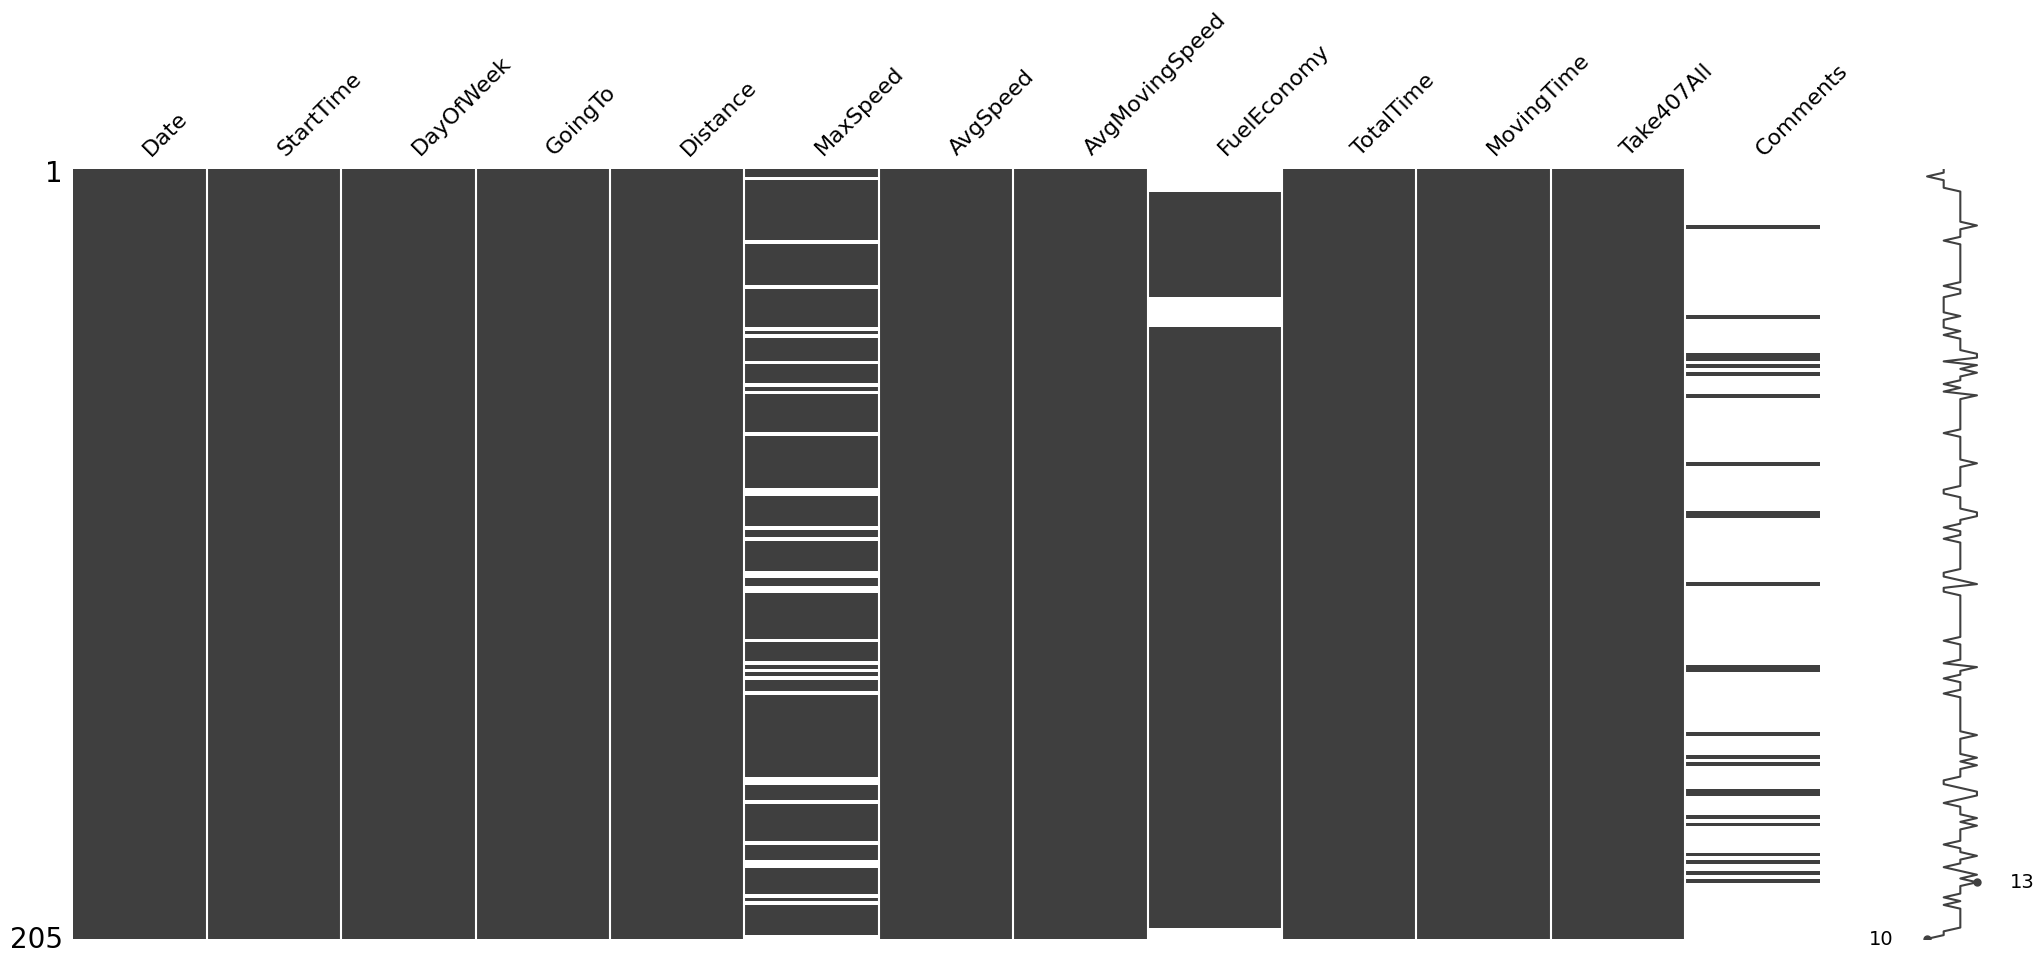

In [14]:
import missingno as msno

msno.matrix(df)

## 1. Basic Imputation Techniques

### 1.1. Mean and Mode Imputation

We can use SimpleImputer function from scikit-learn to replace missing values with a fill value. SimpleImputer function has a parameter called strategy that gives us four possibilities to choose the imputation method:

```strategy='mean'```
replaces missing values using the mean of the column.

```strategy='median'```
replaces missing values using the median of the column.

```strategy='most_frequent'```
 replaces missing values using the most frequent (or mode) of the column.

```strategy='constant'```
replaces missing values using a defined fill value.
Below we are going to use SimpleImputer transformer on MaxSpeed column which has 10% random missing values. We first define the mean imputer with strategy=mean, and then we apply fit_transform on the column.

In [16]:
# Mean Imputation
from sklearn.impute import SimpleImputer

df_mean = df.copy()
mean_imputer = SimpleImputer(strategy='mean')
df_mean['MaxSpeed'] = mean_imputer.fit_transform(df_mean['MaxSpeed'].values.reshape(-1,1))


Let’s plot a scatter plot with AvgSpeed on the x-axis and MaxSpeed on the y-axis. As we know AvgSpeed column doesn’t have missing values, and we replaced missing values in the MaxSpeed column with column mean. In the plot below, green points are transformed data and blue points are original non-missing data.

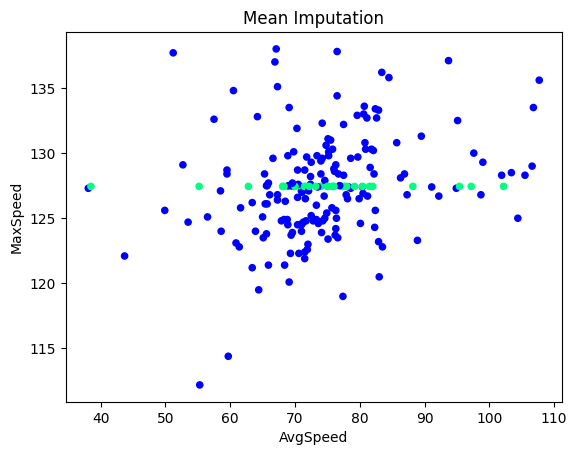

In [18]:
# Scatter plot
import matplotlib.pyplot as plt

fig = plt.Figure()
null_values = df['MaxSpeed'].isnull()
fig = df_mean.plot(x="AvgSpeed", y='MaxSpeed', kind='scatter', c=null_values, cmap='winter', title='Mean Imputation', colorbar=False)


We can repeat the same with median, most-frequent, or constant values. 🌀
Here is the example of imputing with the most frequent value (mode).

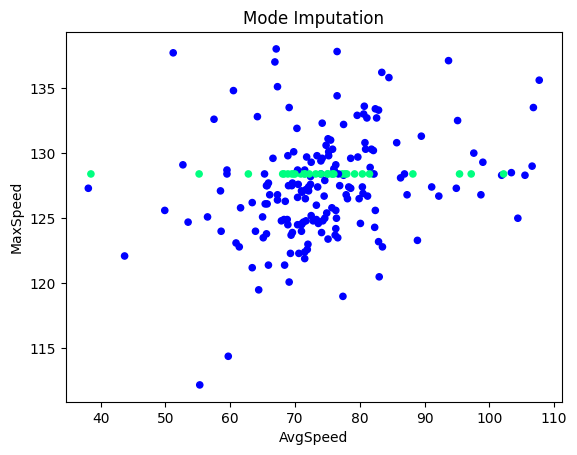

In [19]:
# Mode Imputation

df_mode = df.copy()
mode_imputer = SimpleImputer(strategy='most_frequent')
df_mode['MaxSpeed'] = mode_imputer.fit_transform(df_mode['MaxSpeed'].values.reshape(-1,1))

# Scatter plot

fig = plt.Figure()
null_values = df['MaxSpeed'].isnull()
fig = df_mode.plot(x='AvgSpeed', y='MaxSpeed', kind='scatter', c=null_values, cmap='winter', title='Mode Imputation', colorbar=False)


Note: If there is more than one mode, then imputation uses the minimum mode.

However, mean imputation can bias the standard error and if values are not missing at random can also bias the actual mean/mode of the column. Depending on the volume of missingness, imputing in this way can also affect the true relationship between columns. If the column has many outliers, then median imputation should be preferred over mean imputation.

###1.2. Time Series Imputation




While loading the dataset, we defined the index with the combination of Date and StartTime columns, if that is not clear, see the Data part above.

One way to impute missing values in a time series data is to fill them with either the last or the next observed values. Pandas have fillna() function which has method parameter where we can choose “ffill” to fill with the next observed value or “bfill” to fill with the previously observed value.

Following plot shows the first 100 data points of the MaxSpeed column by time.

<Axes: title={'center': 'MaxSpeed'}>

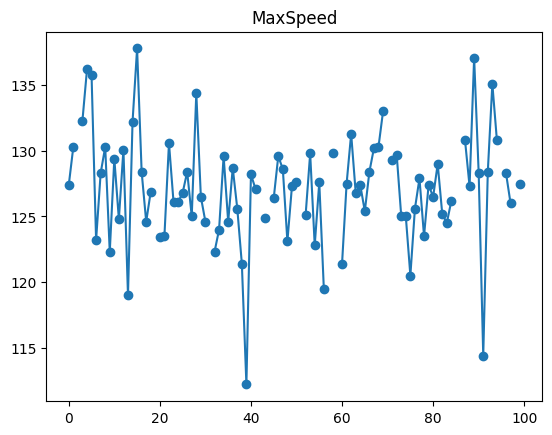

In [20]:
df['MaxSpeed'][:100].plot(title="MaxSpeed", marker="o")

If we want to fill missing values with the next observed value, we should use method=“ffill”.

<Axes: title={'center': 'MaxSpeed'}>

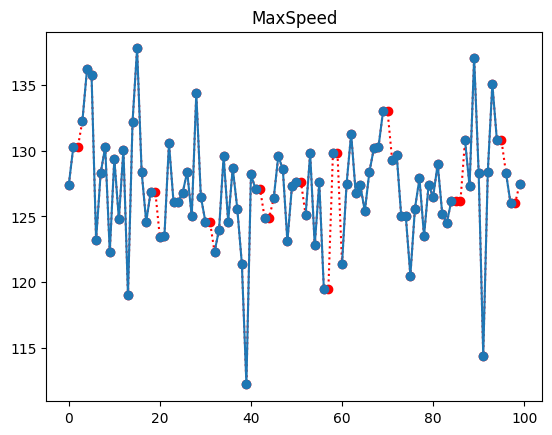

In [24]:
# Ffill imputation
ffill_imp = df.fillna(method='ffill')

# Plot imputed data
ffill_imp['MaxSpeed'][:100].plot(color='red', marker='o', linestyle='dotted')
df['MaxSpeed'][:100].plot(title='MaxSpeed', marker='o')

If we want to fill missing values with the previously observed value, we should use method=“bfill”.

<Axes: title={'center': 'MaxSpeed'}>

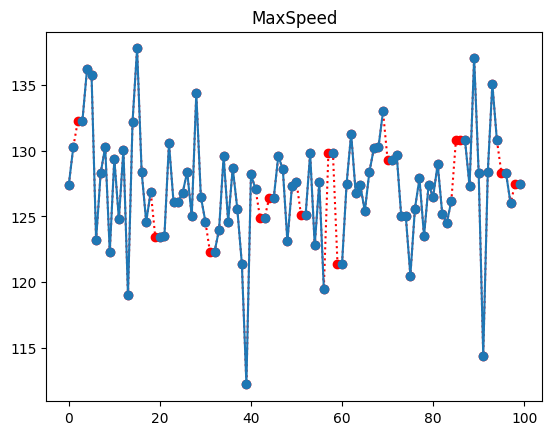

In [25]:
# Bfill imputation
bfill_imp = df.fillna(method='bfill')

# Plot imputed data
bfill_imp['MaxSpeed'][:100].plot(color='red', marker='o', linestyle='dotted')
df['MaxSpeed'][:100].plot(title='MaxSpeed', marker='o')

In addition to bfill and ffill, we can also use interpolate() function from Pandas and select method=“linear” to fill missing values with an increasing order between the previous and next observed values. Important to note that this function threats values as equally spaced by ignoring the index.

<Axes: title={'center': 'MaxSpeed'}>

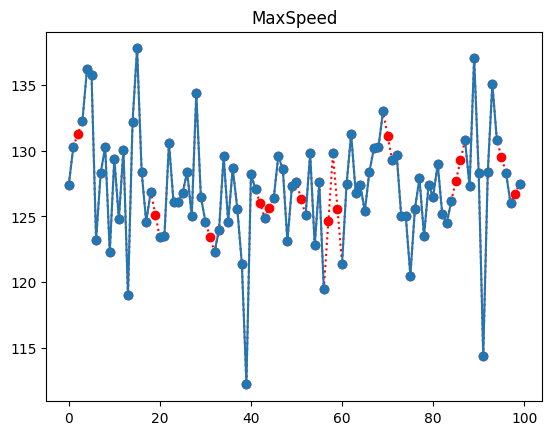

In [26]:
# Imputing with linear interpolation
linear_int = df.interpolate(method='linear')

# Plot imputed data
linear_int['MaxSpeed'][:100].plot(color='red', marker='o', linestyle='dotted')
df['MaxSpeed'][:100].plot(title='MaxSpeed', marker='o')

In addition to method=linear for interpolation, we can also select polynomial, spline, nearest, quadratic, etc. Check out this Pandas documentation if you are interested in interpolation techniques.

##2. Advanced Techniques

###2.1. K-Nearest Neighbour (KNN) Imputation

An alternative way to impute missing values is to predict them. Nearest neighbor imputation is widely used and proven to be an effective way of missing value imputation.

We can use KNNImputer from Scikit-learn, where missing values are imputed using the mean value from K-nearest neighbors found in the training set.

In [27]:
from sklearn.impute import KNNImputer
KNNImputer(missing_values=np.nan, n_neighbors=5, weights='uniform', metric='nan_euclidean')

KNNImputer()

KNNImputer has several parameters such as missing_values which by default set to np.nan, n_neighbors which is the selected number of neighboring samples to use for imputation by default set to 5, metric which is the distance metric for searching neighbors by default set as ‘nan-euclidean’ but can also be defined with user-defined functions.

KNNImputer can work with continuous, discrete and categorical data types but not with text data. Therefore, I filtered the data with a selected subset of columns — Distance, MaxSpeed, AvgSpeed and AvgMoovingSpeed. In addition, I used MinMaxScaler from scikit-learn to normalize this numeric data between 0 and 1. Since KNNImputer is a distance-based algorithm scaling is an important step in the pipeline.

In [28]:
# Imputing with KNNImputer

from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler

#Define a subset of the dataset
df_knn = df.filter(['Distance','MaxSpeed','AvgSpeed','AvgMovingSpeed'], axis=1).copy()

# Define scaler to set values between 0 and 1

scaler = MinMaxScaler(feature_range=(0, 1))
df_knn = pd.DataFrame(scaler.fit_transform(df_knn), columns = df_knn.columns)

# Define KNN imputer and fill missing values
knn_imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')
df_knn_imputed = pd.DataFrame(knn_imputer.fit_transform(df_knn), columns=df_knn.columns)

After defining KNNImputer we fit_transform and save the new (imputed) data. Below there is the scatter plot of the imputed vs original data as before green shows the imputed values of MaxSpeed.

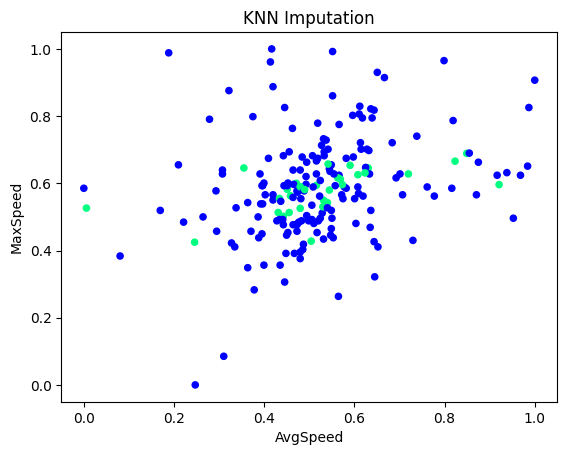

In [29]:
fig = plt.Figure()
null_values = df['MaxSpeed'].isnull() 
fig = df_knn_imputed.plot(x='AvgSpeed', y='MaxSpeed', kind='scatter', c=null_values, cmap='winter', title='KNN Imputation', colorbar=False)

KNNImputer has several advantages like being easy to implement and the ability to work both on numeric and categorical data types. However, defining the number of neighbors — k can be tricky since it introduces a trade-off between robustness and speed. If we select a small k then we have fast computation but less robust results. In contrast, if we select a large k, then we have a more robust but slow computation.

###2.2. Multivariate Imputation by Chained Equation — MICE

MICE algorithm is probably one of the most used imputation techniques and also a popular interview question. 

MICE first calculates the mean of every column where there is a missing value and uses the mean value as a placeholder. Then it runs a series of regression models (chained equations) to impute each missing value sequentially. Like in any regression model, MICE uses a feature matrix and target variable to train, and in this case, the target variable is the column with missing values. MICE predicts and updates missing values on target columns. Iteratively, MICE repeats this process several times by constantly changing the placeholder variables with the predictions from the previous iteration. In the end, it reaches a robust estimation.

To apply MICE algorithm, we will use IterativeImputer from scikit-learn. This estimator is still under experimental so we must import enable_iterative_imputer.

In [33]:
#IterativeImputer(estimator=None, missing_values=np.nan, sample_posterior=False, max_iter=10, tol=0.001, n_nearest_features=None, initial_strategy=’mean’, imputation_order=’ascending’)

In [31]:
# Imputing with MICE
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn import linear_model

df_mice = df.filter(['Distance','MaxSpeed','AvgSpeed','AvgMovingSpeed'], axis=1).copy()

# Define MICE Imputer and fill missing values
mice_imputer = IterativeImputer(estimator=linear_model.BayesianRidge(), n_nearest_features=None, imputation_order='ascending')

df_mice_imputed = pd.DataFrame(mice_imputer.fit_transform(df_mice), columns=df_mice.columns)

Below, see the scatter plot of the imputed vs original data.

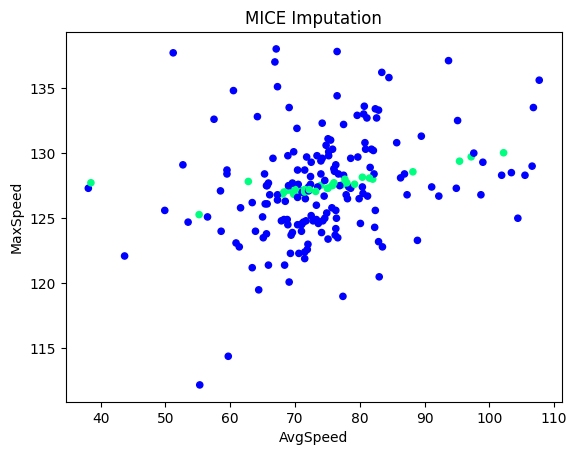

In [34]:
fig = plt.Figure()
null_values = df['MaxSpeed'].isnull() 
fig = df_mice_imputed.plot(x='AvgSpeed', y='MaxSpeed', kind='scatter', c=null_values, cmap='winter', title='MICE Imputation', colorbar=False)

##Conclusion

In this article, we explored different ways to impute missing values in our dataset. We started with detecting missing data using missingno package. Then we used Simple Imputer with the mean and most frequent values of the missing data column. Because of the time element we had in our data, we also discussed back-fill, forward-fill, and linear interpolation to fill missing values using time series. Lastly, we moved to more advanced techniques; K-Nearest Neighbor Imputation (KNN) and Multivariate Imputation by Chained Equations (MICE) which use machine learning to fill missing values.